In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from PIL import Image
import random

In [5]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    
    intersection = tf.reduce_sum(y_true*y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [36]:
H = 256
W = 256
batch_size = 8
lr = 1e-4 #0.0001
num_epochs = 10

In [37]:
# load Data
data_path = "/kaggle/input/deepglobe-road-extraction-dataset/train"
mask_files = sorted(glob(data_path + '/*mask.png'))
sat_files = sorted(glob(data_path + '/*sat.jpg'))
print(len(mask_files), len(sat_files))

0 0


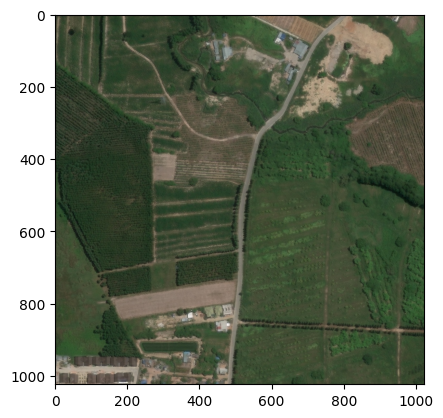

In [38]:
img = plt.imread('C:/Users/BHARGAV/Downloads/road-dataset/train/704600_sat.jpg')
plt.imshow(img)

In [39]:
def load_data(data_path, split=0.2):
    masks = sorted(glob(data_path + '/*mask.png'))
    images = sorted(glob(data_path + '/*sat.jpg'))
    size = int(len(images) * split)
    
    train_x, valid_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=0.2, random_state=42)
    
    train_x, test_x = train_test_split(train_x, test_size=0.2, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=0.2, random_state=42)
    
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [40]:
data_path = "C:/Users/BHARGAV/Downloads/road-dataset/train"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(data_path)

In [41]:
len(train_x), len(train_y), len(valid_x), len(valid_y), len(test_x), len(test_y)

(3984, 3984, 1246, 1246, 996, 996)

In [42]:
def read_image(path):
    try:
        img = Image.open(path)
        img = img.resize((W, H))
        x = np.array(img, dtype=np.float32)
        x = x / 255.0
        return x
    except Exception as e:
        print(f"Error while reading image: {e}")
        return None


def read_mask(path):
    try:
        img = Image.open(path).convert('L')
        img = img.resize((W, H))
        x = np.array(img, dtype=np.float32)
        x = x / 255.0
        x = np.expand_dims(x, axis=-1)
        return x
    except Exception as e:
        print(f"Error while reading mask: {e}")
        return None


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y


def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    
    return dataset

In [43]:
def show_random_sample():
    rand_index =random.randint(0, len(train_x) - 1)
    plt.figure(figsize=(10, 5))  
    plt.subplot(1, 2, 1)  
    plt.imshow(read_image(train_x[rand_index]))
    plt.title('Image')

    plt.subplot(1, 2, 2)  
    plt.imshow(read_mask(train_y[rand_index]))
    plt.title('Mask')

    plt.show()

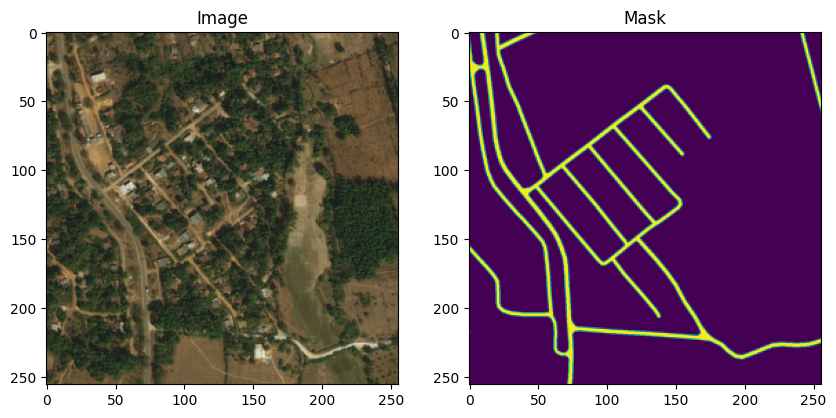

In [44]:
show_random_sample()

In [45]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

train_steps = (len(train_x) // batch_size)
valid_steps = (len(valid_x) // batch_size)

In [46]:
def unet(input_shape):
    # Define input layer
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder part
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder part
    up6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([up6, conv4], axis=-1)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(concat6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv3], axis=-1)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(concat7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    concat8 = tf.keras.layers.concatenate([up8, conv2], axis=-1)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(concat8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    concat9 = tf.keras.layers.concatenate([up9, conv1], axis=-1)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(concat9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1,1,padding="same", activation="sigmoid")(conv9)

    # Create the model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

# Example usage:
input_shape = (256, 256, 3)  # Adjust input shape according to your images


model = unet(input_shape)


In [47]:
model = unet((H,W,3))
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss="binary_crossentropy",
             optimizer=Adam(lr),
             metrics=metrics)

In [48]:
history = model.fit(train_dataset,
                    epochs=num_epochs,
                    validation_data=valid_dataset,
                    steps_per_epoch=train_steps,
                    validation_steps=valid_steps)
model.save("road_model.tf_model")

Epoch 1/10
498/498 [==============================] - 6758s 14s/step - loss: 0.1832 - dice_coef: 0.0676 - iou: 0.0351 - recall_1: 6.8270e-04 - precision_1: 0.0911 - val_loss: 0.1548 - val_dice_coef: 0.0746 - val_iou: 0.0388 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/10
498/498 [==============================] - 6584s 13s/step - loss: 0.1434 - dice_coef: 0.1057 - iou: 0.0560 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.1372 - val_dice_coef: 0.1370 - val_iou: 0.0738 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/10
498/498 [==============================] - 6763s 14s/step - loss: 0.1188 - dice_coef: 0.2242 - iou: 0.1273 - recall_1: 0.0995 - precision_1: 0.7404 - val_loss: 0.1133 - val_dice_coef: 0.2531 - val_iou: 0.1454 - val_recall_1: 0.1173 - val_precision_1: 0.8222
Epoch 4/10
498/498 [==============================] - 6701s 13s/step - loss: 0.1033 - dice_coef: 0.3122 - iou: 0.1859 - recall_1: 0.2203 - precision_1: 0.7671 - val_

INFO:tensorflow:Assets written to: road_model.tf_model\assets


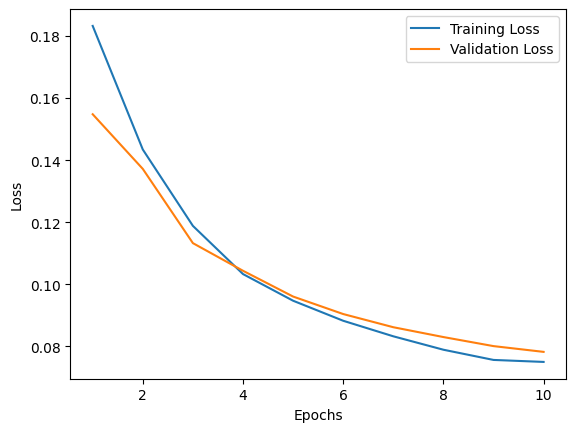

In [49]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a range of epochs for the x-axis
epochs = range(1, len(training_loss) + 1)

# Plot the loss curves
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

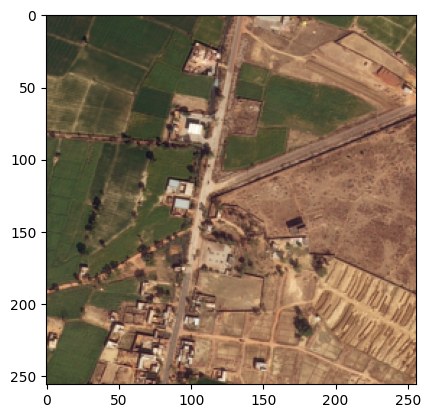

In [56]:
img =read_image("C:/Users/BHARGAV/Downloads/road-dataset/test/987728_sat.jpg")
plt.imshow(img)

In [57]:
img = np.expand_dims(img, axis=0)
img.shape

(1, 256, 256, 3)

1/1 [==============================] - 0s 495ms/step


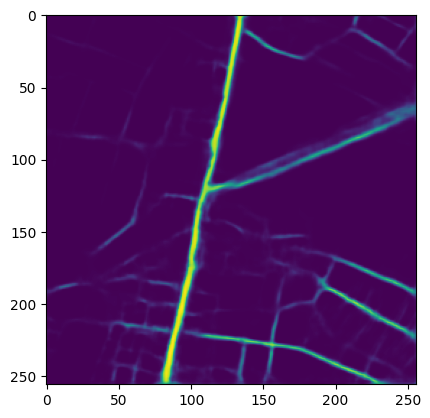

In [58]:
pred = model.predict(img)
plt.imshow(pred[0,...]) 

In [53]:
model.save("raod_model.keras")